In [9]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()

In [2]:
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    obeservation, reward, done, info = env.step(action)
    if done:
        observation = env.reset()
env.close()

In [14]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt 
from tensorflow.keras import layers,optimizers


class Policy(keras.Model):
    # 策略网络，生成动作的概率分布
    def __init__(self):
        super(Policy, self).__init__()
        self.data = [] # 存储轨迹
        # 输入为长度为4的向量，输出为左、右2个动作
        self.fc1 = layers.Dense(128, kernel_initializer='he_normal')
        self.fc2 = layers.Dense(2, kernel_initializer='he_normal')
        # 网络优化器
        self.optimizer = optimizers.Adam(lr=learning_rate)

    def call(self, inputs, training=None):
        # 状态输入s的shape为向量：[4]
        x = tf.nn.relu(self.fc1(inputs))
        x = tf.nn.softmax(self.fc2(x), axis=1)
        return x

    def put_data(self, item):
        # 记录r,log_P(a|s)
        self.data.append(item)

    def train_net(self, tape):
        # 计算梯度并更新策略网络参数。tape为梯度记录器
        R = 0 # 终结状态的初始回报为0
        for r, log_prob in self.data[::-1]:#逆序取
            R = r + gamma * R # 计算每个时间戳上的回报
            # 每个时间戳都计算一次梯度
            # grad_R=-log_P*R*grad_theta
            loss = -log_prob * R
            with tape.stop_recording():
                # 优化策略网络
                grads = tape.gradient(loss, self.trainable_variables)
                # print(grads)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.data = [] # 清空轨迹

/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "policy_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  640       
_________________________________________________________________
dense_3 (Dense)              multiple                  258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
# of episode :20, avg score : 60.4
# of episode :40, avg score : 122.95
# of episode :60, avg score : 145.2
# of episode :80, avg score : 144.45
# of episode :100, avg score : 192.9
# of episode :120, avg score : 214.7
# of episode :140, avg score : 229.65
# of episode :160, avg score : 267.15
# of episode :180, avg score : 240.6
# of episode :200, avg score : 245.8
# of episode :220, avg score : 284.55
# of episode :240, avg score : 287.8
# of episode :260, avg score : 381.15
# of episode :280, avg score : 388.55
# 

/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 24635 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/zhangyunfei_06/opt/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 25253 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/zhangyunfei_06/opt/anaconda3

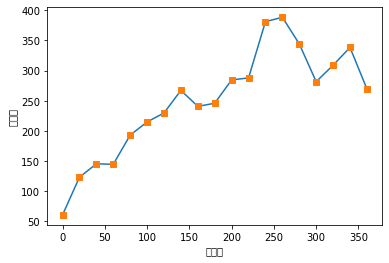

In [15]:
env = gym.make('CartPole-v1')  # 创建游戏环境
env.seed(2333)
tf.random.set_seed(2333)
np.random.seed(2333)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.titlesize'] = 18
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['KaiTi']
matplotlib.rcParams['axes.unicode_minus']=False 


learning_rate = 0.0002
gamma         = 0.98

pi = Policy() # 创建策略网络
pi(tf.random.normal((4,4)))
pi.summary()
score = 0.0 # 计分
print_interval = 20 # 打印间隔
returns = []

for n_epi in range(400):
    s = env.reset() # 回到游戏初始状态，返回s0
    with tf.GradientTape(persistent=True) as tape:
        for t in range(501): # CartPole-v1 forced to terminates at 500 step.
            # 送入状态向量，获取策略
            s = tf.constant(s,dtype=tf.float32)
            # s: [4] => [1,4]
            s = tf.expand_dims(s, axis=0)
            prob = pi(s) # 动作分布:[1,2]
            # 从类别分布中采样1个动作, shape: [1]
            a = tf.random.categorical(tf.math.log(prob), 1)[0]
            a = int(a) # Tensor转数字
            s_prime, r, done, info = env.step(a)
            # 记录动作a和动作产生的奖励r
            # prob shape:[1,2]
            pi.put_data((r, tf.math.log(prob[0][a])))
            s = s_prime # 刷新状态
            score += r # 累积奖励

            if n_epi >1000:
                env.render()
                # im = Image.fromarray(s)
                # im.save("res/%d.jpg" % info['frames'][0])

            if done:  # 当前episode终止
                break
        # episode终止后，训练一次网络
        pi.train_net(tape)
    del tape

    if n_epi%print_interval==0 and n_epi!=0:
        returns.append(score/print_interval)
        print(f"# of episode :{n_epi}, avg score : {score/print_interval}")
        score = 0.0
env.close() # 关闭环境

plt.plot(np.arange(len(returns))*print_interval, returns)
plt.plot(np.arange(len(returns))*print_interval, returns, 's')
plt.xlabel('回合数')
plt.ylabel('总回报')
plt.savefig('reinforce-tf-cartpole.svg')